12/17/18
BTC Prediction

In [1]:
import requests
import io
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

In [2]:
# 1Token's API address
tokenapi = 'http://hist-quote.1tokentrade.cn'

In [3]:
# Retrieve API token
current_path = os.getcwd()
with open(current_path + '/token.txt') as file:
    ot_key = file.read().splitlines()[0]

In [4]:
# @hidden_cell
# Query all contracts for a certain date
params = {
    'date' : '2018-02-02',
}
# r = requests.get(tokenapi + '/ticks/contracts', headers = {'ot-key' : ot_key}, params = params)
# r.json()

In [5]:
# Query a single price at date/contract
params = {
    'contract' : 'binance/btc.usdt',
    'date' : '2018-02-02',
}
# r = requests.get(tokenapi + '/ticks/simple' , headers = {'ot-key' : ot_key}, params = params)
# r

In [6]:
# Query "candlestick" data
params = {
#     'since' : '2013-12-10',
#     'since' : '2017-12-21',
    'since' : '2018-12-11',
    'until' : '2018-12-21',
    'contract' : 'binance/btc.usdt',
#     'duration' : '1d',
    'duration' : '1m',
    'format' : 'csv'
}
r = requests.get(tokenapi + '/candles' , headers = {'ot-key' : ot_key}, params = params, stream = True)

# Write to local file
df = pd.read_csv(io.StringIO(r.text))   
df.to_csv(current_path + '/btc-historical-data.csv')
print("Number of rows:", df.size / 6)
df.head()

Number of rows: 14400.0


,close,high,low,open,timestamp,volume
0,3433.40,3436.78,3432.39,3434.01,1544486400,19.362386
1,3425.85,3435.26,3424.01,3433.62,1544486460,49.151693
2,3423.26,3431.02,3423.26,3428.00,1544486520,9.487126
3,3425.19,3427.95,3423.57,3424.52,1544486580,10.325669
4,3422.83,3426.81,3422.67,3425.20,1544486640,8.280380


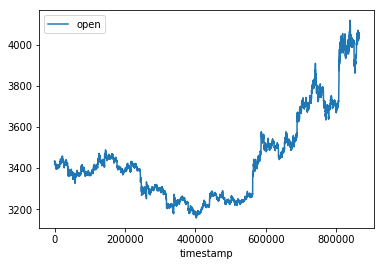

In [7]:
# Plot opening price across entire set
df_plot = df.drop(labels=['close', 'high', 'low', 'volume'], axis=1)
earliest_timestamp = df_plot['timestamp'][0]
# df_plot['timestamp'] = df_plot['timestamp'].apply(lambda x : (x - earliest_timestamp) / 60 / 60 / 24)
df_plot['timestamp'] = df_plot['timestamp'].apply(lambda x : (x - earliest_timestamp))
df_plot.plot(x = 'timestamp', y = 'open')

In [9]:
# Split training/testing data
percent_training = .8
div = math.floor(len(df) * percent_training)
training = df.drop(labels=np.arange(len(df))[div:])
testing = df.drop(labels=np.arange(len(df))[:div])
print("Split data such that training has " + str(len(training)) + \
      " points, and testing has " + str(len(testing)) + " points.")

Split data such that training has 11520 points, and testing has 2880 points.


In [11]:
# training['label'] = training.apply(lambda row : 'long' if row['open'] < row['close'] else 'short', axis=1)
training.head()

,close,high,low,open,timestamp,volume
0,3433.40,3436.78,3432.39,3434.01,1544486400,19.362386
1,3425.85,3435.26,3424.01,3433.62,1544486460,49.151693
2,3423.26,3431.02,3423.26,3428.00,1544486520,9.487126
3,3425.19,3427.95,3423.57,3424.52,1544486580,10.325669
4,3422.83,3426.81,3422.67,3425.20,1544486640,8.280380
